   *«Нужно больше золота.»*

   -- Нежить, Послушник

# Восстановление золота из руды

В данной работе будет подготовлена модель машинного обучения, способная предсказывать коэффициент восстановления золота из золотосодержащей руды, используя данные с параметрами добычи.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

Извлечём данные и посмотрим на них.

In [2]:
train = pd.read_csv('/datasets/gold_industry_train.csv')
test = pd.read_csv('/datasets/gold_industry_test.csv')
full = pd.read_csv('/datasets/gold_industry_full.csv')

### Проверка эффективности обогащения

<a name="m1"></a>

Проверим расчёт эффективности обогащения золотом после флотации и после всех процессов в обучающей выборке.

In [3]:
# функция расчитывает эффективность обогащения после флотации или любого этапа очистки
# доля вещества на выходе, доля вещества на входе, доля вещества в отвальных хвостах
def bogat(c,f,t):
    return c * (f - t) / f / (c - t)

(bogat(train['rougher.output.concentrate_au'],
      train['rougher.input.feed_au'],
      train['rougher.output.tail_au']
     ) * 100).mean()

82.52119968211336

Среднеквадратичное отклонение между расчитанными данными и оригинальными пренебрежимо мало, что свидетельтсвует о правильности расчётов эффективности обогащения золотом после флотации в обучающей выборке.

In [4]:
mae(train['rougher.output.recovery'],
    bogat(train['rougher.output.concentrate_au'],
      train['rougher.input.feed_au'],
      train['rougher.output.tail_au']
     ) * 100
   )

1.0851689485498649e-14

Тоже самое можно сказать и о расчёте эффективности всего процесса обогащения.

In [5]:
mae(train['final.output.recovery'],
    bogat(train['final.output.concentrate_au'],
      train['rougher.input.feed_au'],
      train['final.output.tail_au']
     ) * 100
   )

9.218759616408752e-15

### Тестовая выборка

Сначала посмотрим на состав тестовой выборки.

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

Переведём данные о времени в более подходящий для работы вид.

In [7]:
test['date'] = pd.to_datetime(
    test['date'], format='%Y-%m-%d %H:%M:%S'
)

В данных большое количество пропусков в которых не удалось найти какой-либо системы. Исходя из предположения, что пропущенные значения являются результатом некой технической ошибки, можно было бы удалить все строки, содержащие пропуски, но это приведёт к некоторому сокращению объёма имеющихся данных, так что попробуем рассмотреть ситуацию более детально.

In [8]:
test.dropna()['date'].count() / test['date'].count()

0.9335390946502058

За отсутвием лучшего варианта, интерпритируем знание о том, что "Соседние по времени параметры часто похожи.", таким образом, что станет возможно линейно заполнить недостающие значения.

In [9]:
# берёт на вход series, линейно заполняет в нём пропуски, надеется, что пропусков нет в начале и конце series
def nospace_line(a):
    index = a[a.isna()].index
    i = 0
    while (i < len(index)):
        n = 0
        while True:
            n = n + 1
            if (i + n == len(index)):
                break
            if (index[i] + n != index[i + n]):
                break
        j = n
        while (n != 0):
            a[index[i + n - 1]] = (a[index[i] + j] - a[index[i] - 1]) * (n / (j + 1)) + a[index[i] - 1]
            n = n - 1
        i = i + j


for i in test.isna().sum()[test.isna().sum() != 0].index:
    nospace_line(test[i])

/tmp/ipykernel_116/1416461612.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a[index[i + n - 1]] = (a[index[i] + j] - a[index[i] - 1]) * (n / (j + 1)) + a[index[i] - 1]


Таким образом пропуски в данных оказались заполнены.

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        4860 non-null   datetime64[ns]
 1   rougher.input.feed_au                       4860 non-null   float64       
 2   rougher.input.feed_ag                       4860 non-null   float64       
 3   rougher.input.feed_pb                       4860 non-null   float64       
 4   rougher.input.feed_sol                      4860 non-null   float64       
 5   rougher.input.feed_rate                     4860 non-null   float64       
 6   rougher.input.feed_size                     4860 non-null   float64       
 7   rougher.input.floatbank10_sulfate           4860 non-null   float64       
 8   rougher.input.floatbank10_xanthate          4860 non-null   float64       
 9   rougher.

---

Существуют признаки, показывающие внушительную суммарную корреляцию с остальными признаками имеющихся данных. Из вывода ниже видно, что особенно большие числа данного показателя получаются при рассмотрении статуса "воздуха" и "уровня".

In [11]:
(test.corr().abs().sum() - 1).sort_values(ascending=False)

rougher.state.floatbank10_c_air               13.017274
rougher.state.floatbank10_c_level             12.846421
rougher.state.floatbank10_e_level             12.709060
rougher.state.floatbank10_d_level             12.698248
secondary_cleaner.state.floatbank6_a_air      12.682838
rougher.state.floatbank10_f_level             12.615922
rougher.state.floatbank10_b_level             12.607859
rougher.state.floatbank10_d_air               12.600829
rougher.state.floatbank10_b_air               12.541253
secondary_cleaner.state.floatbank5_b_air      12.425363
secondary_cleaner.state.floatbank5_a_air      12.347645
secondary_cleaner.state.floatbank4_a_air      12.205562
primary_cleaner.state.floatbank8_a_air        11.829809
secondary_cleaner.state.floatbank4_b_air      11.794457
primary_cleaner.state.floatbank8_c_air        11.766593
rougher.state.floatbank10_e_air               10.871534
primary_cleaner.state.floatbank8_b_air        10.863286
rougher.state.floatbank10_a_level             10

Рассмотрим некоторые строки матрицы корреляции более детально. Из выводов ниже не следует, что первые три признака, несмотря на большую корреляцию друг между другом не являются одним и тем же признаком, поскольку имеют разные кореляции с другими признаками, поэтому в дальнейшем анализе имеет смысл не исключать такие столбцы из рассматриваемых данных. В дальнейшем анализе мы будем предполагать, что все рассматриваемые данные имеют друг между другом корреляции подобного рода или не имеют корреляций вовсе, если явно не будет указано иного.

In [12]:
test.corr()['primary_cleaner.state.floatbank8_a_air'].abs().sort_values(ascending=False).head(12)

primary_cleaner.state.floatbank8_a_air      1.000000
primary_cleaner.state.floatbank8_b_air      0.921953
primary_cleaner.state.floatbank8_c_air      0.899784
secondary_cleaner.state.floatbank5_a_air    0.514782
secondary_cleaner.state.floatbank4_a_air    0.485548
secondary_cleaner.state.floatbank5_b_air    0.480122
secondary_cleaner.state.floatbank4_b_air    0.475223
secondary_cleaner.state.floatbank3_a_air    0.434888
rougher.state.floatbank10_a_air             0.373165
secondary_cleaner.state.floatbank3_b_air    0.361719
rougher.state.floatbank10_b_level           0.357625
secondary_cleaner.state.floatbank6_a_air    0.352898
Name: primary_cleaner.state.floatbank8_a_air, dtype: float64

In [13]:
test.corr()['primary_cleaner.state.floatbank8_b_air'].abs().sort_values(ascending=False).head(12)

primary_cleaner.state.floatbank8_b_air      1.000000
primary_cleaner.state.floatbank8_a_air      0.921953
primary_cleaner.state.floatbank8_c_air      0.907184
secondary_cleaner.state.floatbank5_a_air    0.460774
secondary_cleaner.state.floatbank4_a_air    0.410043
secondary_cleaner.state.floatbank4_b_air    0.409528
rougher.state.floatbank10_a_air             0.399532
secondary_cleaner.state.floatbank5_b_air    0.391698
primary_cleaner.state.floatbank8_d_air      0.362273
secondary_cleaner.state.floatbank3_a_air    0.357407
rougher.state.floatbank10_b_level           0.356039
rougher.state.floatbank10_e_level           0.354788
Name: primary_cleaner.state.floatbank8_b_air, dtype: float64

In [14]:
test.corr()['primary_cleaner.state.floatbank8_c_air'].abs().sort_values(ascending=False).head(12)

primary_cleaner.state.floatbank8_c_air      1.000000
primary_cleaner.state.floatbank8_b_air      0.907184
primary_cleaner.state.floatbank8_a_air      0.899784
secondary_cleaner.state.floatbank5_a_air    0.552216
secondary_cleaner.state.floatbank5_b_air    0.509491
secondary_cleaner.state.floatbank4_a_air    0.503327
secondary_cleaner.state.floatbank4_b_air    0.492605
secondary_cleaner.state.floatbank3_a_air    0.438425
rougher.state.floatbank10_a_air             0.408262
secondary_cleaner.state.floatbank3_b_air    0.348870
primary_cleaner.state.floatbank8_d_air      0.346264
rougher.state.floatbank10_e_level           0.330885
Name: primary_cleaner.state.floatbank8_c_air, dtype: float64

### Обучающая выборка

Далее взглянем на обучающую выборку.

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


Переведём данные о времени в более подходящий для работы вид.

In [16]:
train['date'] = pd.to_datetime(
    train['date'], format='%Y-%m-%d %H:%M:%S'
)

Стоит исключить все посчитанные данные (calculation), поскольку они могут быть получены из других данных из обучающей выборки. Исходя из названий можно предположить, что у них нет линейной зависимости с другими данными, но есть нелинейная зависимость с ними, что может несколько запутать модели, которые будут в дальнейшем работать с этими данными.

In [17]:
train = train.drop(['rougher.calculation.sulfate_to_au_concentrate',
                    'rougher.calculation.floatbank10_sulfate_to_au_feed',
                    'rougher.calculation.floatbank11_sulfate_to_au_feed',
                    'rougher.calculation.au_pb_ratio'
                   ], axis=1)

В данных большое количество пропусков в которых не удалось найти какой-либо системы. Исходя из предположения, что пропущенные значения являются результатом некой технической ошибки, можно было бы удалить все строки, содержащие пропуски, но это приведёт к некоторому сокращению объёма имеющихся данных, так что попробуем рассмотреть ситуацию более детально.

In [18]:
train.dropna()['date'].count() / train['date'].count()

0.8462171616708964

За отсутвием лучшего варианта, интерпритируем знание о том, что "Соседние по времени параметры часто похожи.", таким образом, что станет возможно линейно заполнить недостающие значения.

In [19]:
for i in train.isna().sum()[train.isna().sum() != 0].index:
    nospace_line(train[i])

/tmp/ipykernel_116/1416461612.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a[index[i + n - 1]] = (a[index[i] + j] - a[index[i] - 1]) * (n / (j + 1)) + a[index[i] - 1]


Таким образом пропуски в данных оказались заполнены.

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 83 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        14579 non-null  datetime64[ns]
 1   rougher.input.feed_au                       14579 non-null  float64       
 2   rougher.input.feed_ag                       14579 non-null  float64       
 3   rougher.input.feed_pb                       14579 non-null  float64       
 4   rougher.input.feed_sol                      14579 non-null  float64       
 5   rougher.input.feed_rate                     14579 non-null  float64       
 6   rougher.input.feed_size                     14579 non-null  float64       
 7   rougher.input.floatbank10_sulfate           14579 non-null  float64       
 8   rougher.input.floatbank10_xanthate          14579 non-null  float64       
 9   roughe

Можно также показать высокую суммарную корреляцию у ряда признаков друг между другом.

In [21]:
(train.corr().abs().sum() - 1).sort_values(ascending=False)

rougher.state.floatbank10_c_air               18.760035
rougher.state.floatbank10_d_air               18.740545
rougher.state.floatbank10_c_level             18.707545
rougher.state.floatbank10_b_level             18.615291
rougher.state.floatbank10_b_air               18.503336
                                                ...    
primary_cleaner.state.floatbank8_d_level       7.775185
final.output.concentrate_pb                    6.807348
secondary_cleaner.state.floatbank6_a_level     6.485972
rougher.input.feed_size                        6.425859
final.output.concentrate_au                    5.768116
Length: 82, dtype: float64

### Исходные данные

Посмотрим на исходные данные.

In [22]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


Переведём данные о времени в более подходящий для работы вид.

In [23]:
full['date'] = pd.to_datetime(
    full['date'], format='%Y-%m-%d %H:%M:%S'
)

В данных большое количество пропусков в которых не удалось найти какой-либо системы. Исходя из предположения, что пропущенные значения являются результатом некой технической ошибки, можно было бы удалить все строки, содержащие пропуски, но это приведёт к некоторому сокращению объёма имеющихся данных, так что попробуем рассмотреть ситуацию более детально.

In [24]:
full.dropna()['date'].count() / full['date'].count()

0.8279232470806112

За отсутвием лучшего варианта, интерпритируем знание о том, что "Соседние по времени параметры часто похожи.", таким образом, что станет возможно линейно заполнить недостающие значения.

In [25]:
for i in full.isna().sum()[full.isna().sum() != 0].index:
    nospace_line(full[i])

/tmp/ipykernel_116/1416461612.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a[index[i + n - 1]] = (a[index[i] + j] - a[index[i] - 1]) * (n / (j + 1)) + a[index[i] - 1]


Таким образом пропуски в данных оказались заполнены.

In [26]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   rougher.input.feed_au                               19439 non-null  float64       
 2   rougher.input.feed_ag                               19439 non-null  float64       
 3   rougher.input.feed_pb                               19439 non-null  float64       
 4   rougher.input.feed_sol                              19439 non-null  float64       
 5   rougher.input.feed_rate                             19439 non-null  float64       
 6   rougher.input.feed_size                             19439 non-null  float64       
 7   rougher.input.floatbank10_sulfate                   19439 non-null  float64       
 8   roughe

Можно также показать высокую суммарную корреляцию у ряда признаков друг между другом.

In [27]:
(full.corr().abs().sum() - 1).sort_values(ascending=False)

primary_cleaner.output.tail_pb                        19.133651
rougher.state.floatbank10_c_air                       18.920251
secondary_cleaner.output.tail_pb                      18.907617
rougher.state.floatbank10_d_air                       18.789020
rougher.state.floatbank10_b_air                       18.519469
                                                        ...    
secondary_cleaner.state.floatbank6_a_level             6.548981
final.output.concentrate_au                            5.914409
rougher.calculation.floatbank10_sulfate_to_au_feed     3.932719
rougher.calculation.floatbank11_sulfate_to_au_feed     2.930938
rougher.calculation.sulfate_to_au_concentrate          0.576996
Length: 86, dtype: float64

---

Можно заметить, что в тестовой выборке не указаны расчётные характеристики. Это связано с тем, что данные величины расчитываются или замеряются несколько позже сбора данных тестовой выборки и не могут быть доступны из неё. Кроме того в тестовой выборке не указаны параметры сырья на всех этапах очистки и финальные характеристики продукта, поскольку данные признаки являются целевыми и не могут быть отнесены к состовляющей тестовой выборки. Они сами являются объектом предсказания, а не признаком данного анализа.

## Анализ данных

Чтобы лучше представлять себе суть происходящих с сырьём процессов проанализируем изменение концентраций различных металов в сырье и сравним распределения размеров гранул в обучающей и тестовой выборках.

### Концентрации металлов

Проанализируем изменение распределений концетраций металлов на различных этапах обработки. Эта часть анализа будет произведена на полных данных, чтобы получить наиболее ёмкое представление о происходящем.

#### Свинец

Входящее распределение концентрации свинца имеет нормальный вид с медианой в ~3,5%.

Text(0.5, 0, 'концентрация, %')

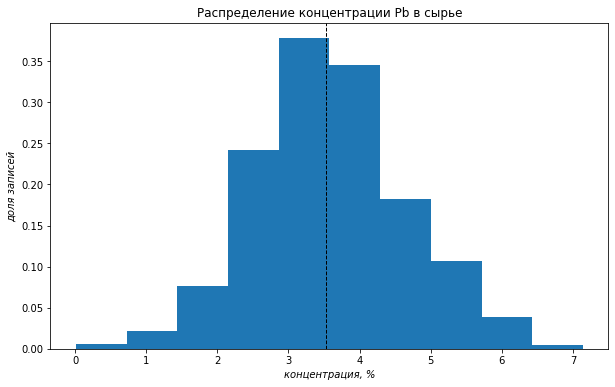

In [28]:
full['rougher.input.feed_pb'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['rougher.input.feed_pb'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Pb в сырье')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Видно, что после обработки распределение сместилось "вправо", в сторону увеличения концентрации металла. медиана при этом выросла до ~8%. Однако заметно, что в отдельных случаях после этапа флотации концентрация падает почти до нуля.

Text(0.5, 0, 'концентрация, %')

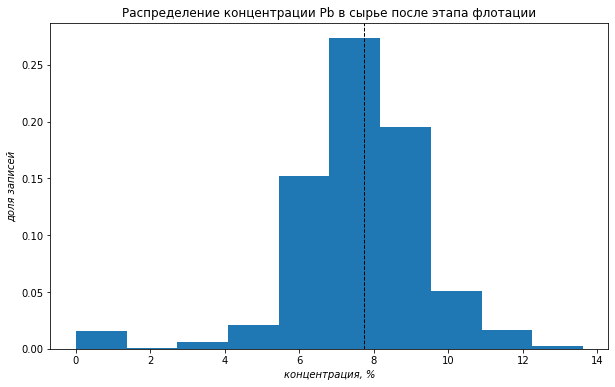

In [29]:
full['rougher.output.concentrate_pb'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['rougher.output.concentrate_pb'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Pb в сырье после этапа флотации')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Распределение концентрации в отвальном хвосте имеет больше Пуассоновский вид с медианой ~0.5%.

Text(0.5, 0, 'концентрация, %')

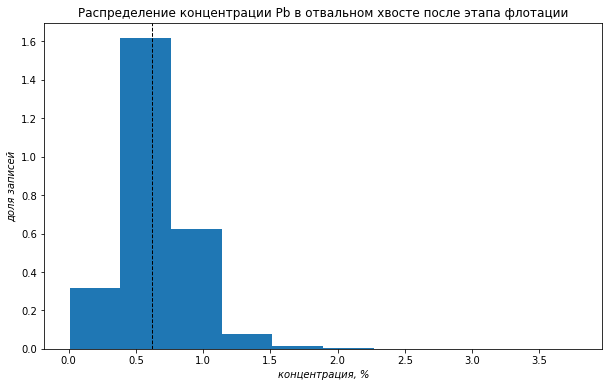

In [30]:
full['rougher.output.tail_pb'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['rougher.output.tail_pb'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Pb в отвальном хвосте после этапа флотации')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Грубая очистка повышает концентрацию свинца, но в отдельных случаях может понизить её до нуля.

---

После первого этапа очистки распределение снова "двигается" в сторогну увеличения концентрации, медиана при этом ~10%.

Text(0.5, 0, 'концентрация, %')

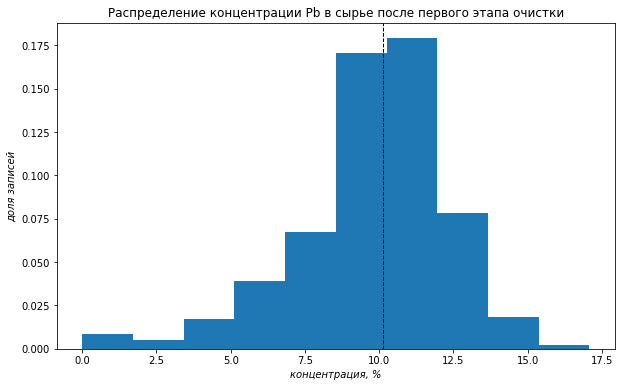

In [31]:
full['primary_cleaner.output.concentrate_pb'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['primary_cleaner.output.concentrate_pb'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Pb в сырье после первого этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Распределение концентрации в отвальном хвосте имеет более нормальный вид, чем распределение концентрации в отвальном хвосте после грубой очистки, также можно заметить увеличение медианы этого распределения в ~6 раз.

Text(0.5, 0, 'концентрация, %')

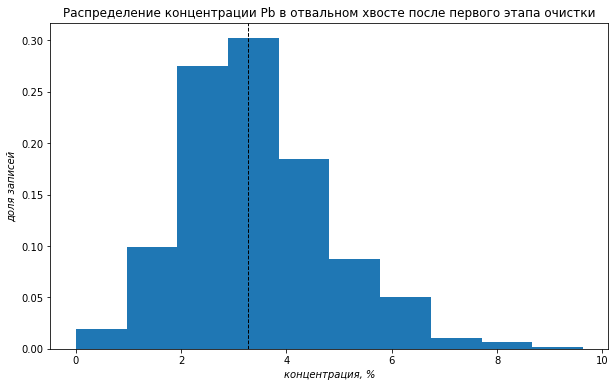

In [32]:
full['primary_cleaner.output.tail_pb'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['primary_cleaner.output.tail_pb'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Pb в отвальном хвосте после первого этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Первый этап очистки также как и грубыая очистка повышает концентрацию свинца в сырье. 

---

Второй этап очистки почти никак не затрагивает медиану распределения концентрации свинца, однако уменьшает его дисперсию.

Text(0.5, 0, 'концентрация, %')

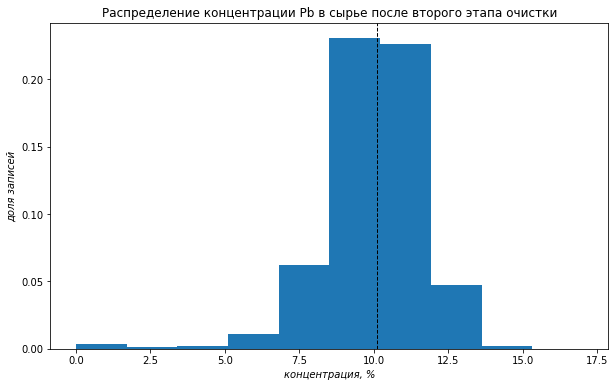

In [33]:
full['final.output.concentrate_pb'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['final.output.concentrate_pb'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Pb в сырье после второго этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Последнее распределение отвального хвоста более всего близко к нормальному из всех распределений отвальных хвостов свинца, медиана данного распределения несколько ниже медианы распределения отвального хвоста на предыдущем этапе.

Text(0.5, 0, 'концентрация, %')

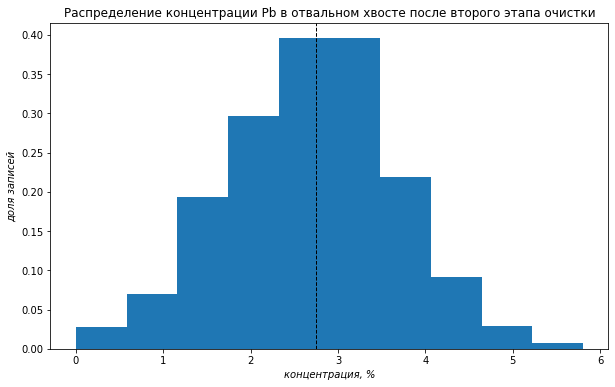

In [34]:
full['final.output.tail_pb'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['final.output.tail_pb'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Pb в отвальном хвосте после второго этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Второй этап очистки не влияет на медиану распределения концентрации свинца, но делает это распределение менее дисперсным. Итоговая концентрация свинца после всех циклов очистки выше, чем концентрация свинца в оригинальном сырье.

#### Серебро

Входящее распределение концентрации серебра похоже на нормальное распределение с медианой ~8%.

Text(0.5, 0, 'концентрация, %')

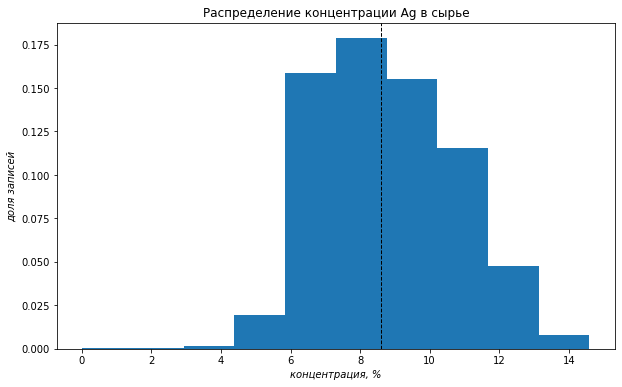

In [35]:
full['rougher.input.feed_ag'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['rougher.input.feed_ag'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Ag в сырье')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

После грубой очистки распределение сместилось в сторону увеличения концентрации, таким образом, что медианная концентрация серебра стала равна ~12%. Однако в некоторых случаях концентрация серебра падает почти до нуля, как это происходит со свинцом.

Text(0.5, 0, 'концентрация, %')

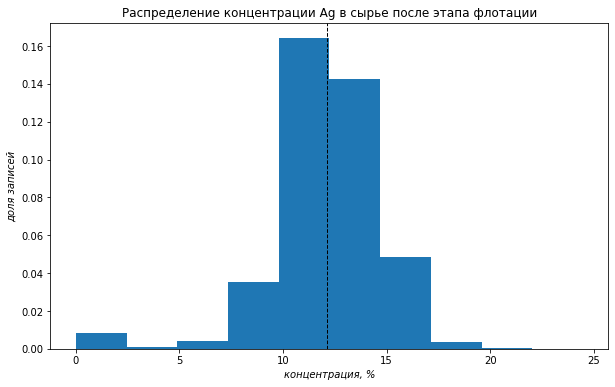

In [36]:
full['rougher.output.concentrate_ag'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['rougher.output.concentrate_ag'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Ag в сырье после этапа флотации')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

В отвальном хвосте наблюдается ненулевая концентрация серебра с медианой ~6%.

Text(0.5, 0, 'концентрация, %')

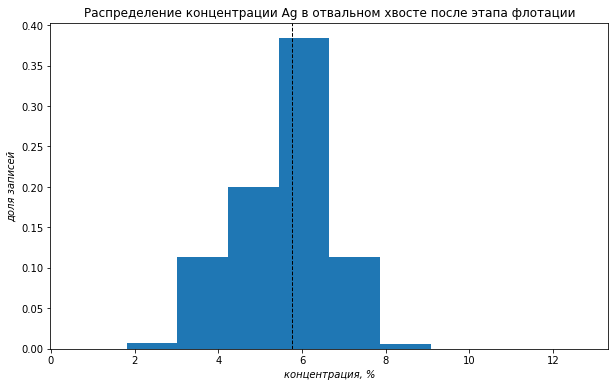

In [37]:
full['rougher.output.tail_ag'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['rougher.output.tail_ag'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Ag в отвальном хвосте после этапа флотации')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

После грубой очистки концентрация серебра в сырье повышается.

---

После первого этапа очистки распределение концентрации серебра сдвигается в сторону уменьшения и принамет более нормальный вид. Медиана распределения после данного этапа становится равной ~8%.

Text(0.5, 0, 'концентрация, %')

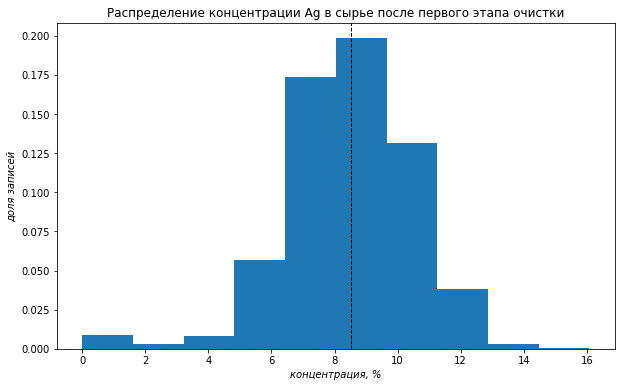

In [38]:
full['primary_cleaner.output.concentrate_ag'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['primary_cleaner.output.concentrate_ag'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Ag в сырье после первого этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Распределение концентрации серебра в отвальном хвосте напротив, сильно смещается в сторону увеличения, таким образом медиана распределения концентрации серебра в отвальном хвосте становится выше медианы распределения концентрации в сырье.

Text(0.5, 0, 'концентрация, %')

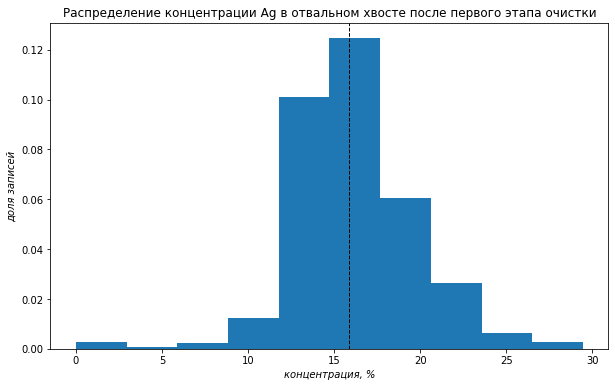

In [39]:
full['primary_cleaner.output.tail_ag'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['primary_cleaner.output.tail_ag'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Ag в отвальном хвосте после первого этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

На этапе первой очистки концентрация серебра в сырье снижается.

---

Второй этап очистки также сдвигает распределение концентрации серебра в сторону уменьшения, делая медиану такого распределения ~5%. Кроме того данный этап уменьшает дисперсию распределния.

Text(0.5, 0, 'концентрация, %')

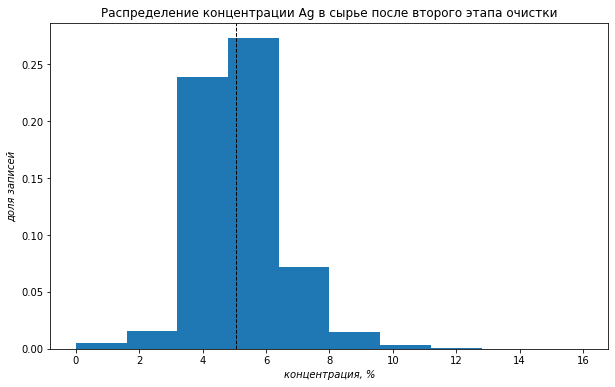

In [40]:
full['final.output.concentrate_ag'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['final.output.concentrate_ag'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Ag в сырье после второго этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Распределение концентрации серебра в отвальном хвосте при этом имеет нормальный вид с медианой ~10%.

Text(0.5, 0, 'концентрация, %')

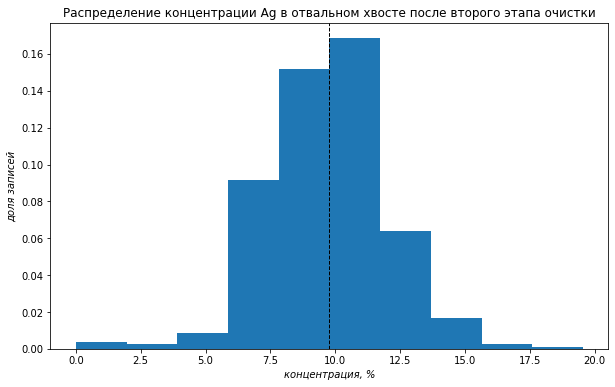

In [41]:
full['final.output.tail_ag'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['final.output.tail_ag'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Ag в отвальном хвосте после второго этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Также как и первый, второй этап очистки снижает концентрацию серебра в сырье. Итоговая концентрация серебра меньше, концентрации серебра в изначальном сырье.

#### Золото

Входящее распределение концентрации золота в образце похоже на входящее распределение серебра, однако медиана распределения золота несколько ниже медианы распределения серебра и составляеет ~8%.

Text(0.5, 0, 'концентрация, %')

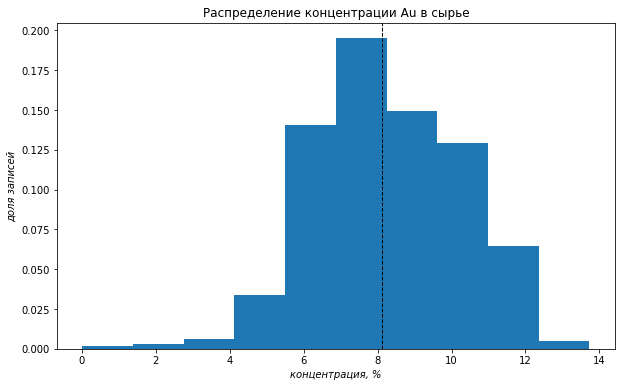

In [42]:
full['rougher.input.feed_au'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['rougher.input.feed_au'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Au в сырье')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

После этапа грубой очистки распределение концентрации золота в сырье стремится в сторону увеличения, дисперсия распределения становится меньше, а медиана становится равной ~20%. Также, как и с предыдущими металлами в отдельных случаях концентрация золота в сырье становится близкой к нулевой.

Text(0.5, 0, 'концентрация, %')

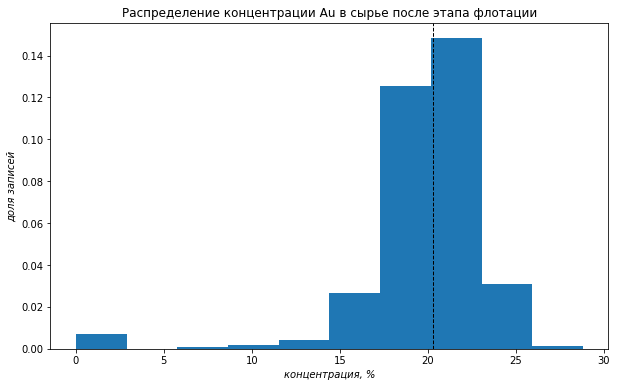

In [43]:
full['rougher.output.concentrate_au'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['rougher.output.concentrate_au'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Au в сырье после этапа флотации')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Концентрация золота в отвальном хвосте имеет медиану ~2%.

Text(0.5, 0, 'концентрация, %')

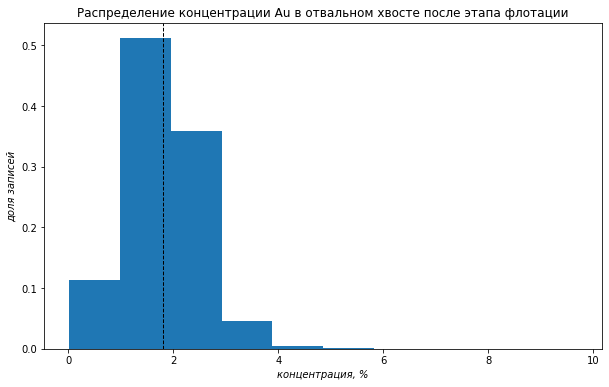

In [44]:
full['rougher.output.tail_au'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['rougher.output.tail_au'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Au в отвальном хвосте после этапа флотации')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

После этапа грубой очистки концентрация золота в сырье значительно повышается.

---

После первого этапа очистки распределение концентрации золота в сырье продолжает сдвигаться в сторону увеличения, имея медиану ~33%.

Text(0.5, 0, 'концентрация, %')

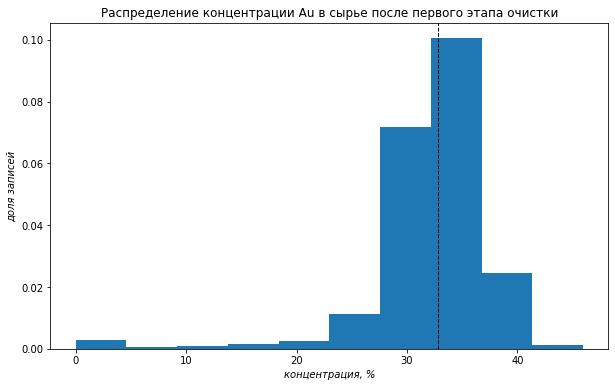

In [45]:
full['primary_cleaner.output.concentrate_au'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['primary_cleaner.output.concentrate_au'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Au в сырье после первого этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

После первого этапа очистки распределение золота в отвальном хвосте имеет медиану ~3%.

Text(0.5, 0, 'концентрация, %')

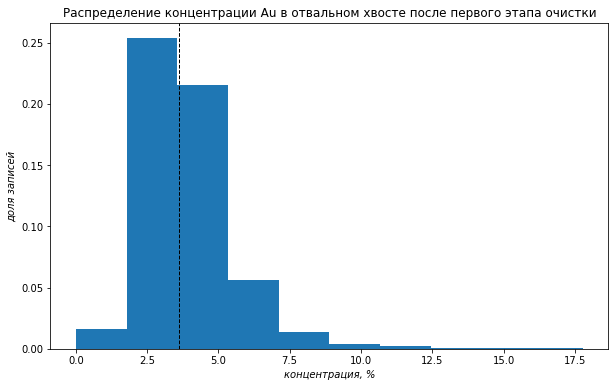

In [46]:
full['primary_cleaner.output.tail_au'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['primary_cleaner.output.tail_au'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Au в отвальном хвосте после первого этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

После первого этапа очистки концентрация золота продолжает повышатся.

---

После второго этапа очистки распределение концентрации золота имеет меньшую дисперсию, чем распределение концентрации предыдущего этапа и увеличенную медиану, значение которой становится равным ~45%

Text(0.5, 0, 'концентрация, %')

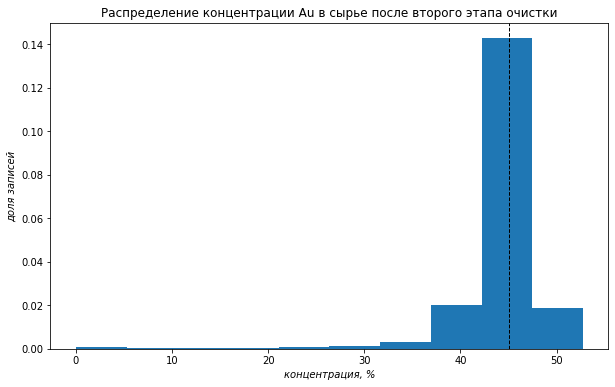

In [47]:
full['final.output.concentrate_au'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['final.output.concentrate_au'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Au в сырье после второго этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Распределение золота в отвальном хвосте второго этапа имеет большую дисперсию, чем аналогичное распределение на предыдущем этапе и примерно такую же медиану.

Text(0.5, 0, 'концентрация, %')

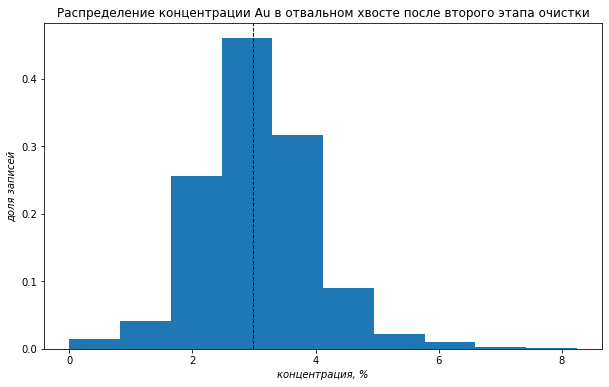

In [48]:
full['final.output.tail_au'].hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=full['final.output.tail_au'].median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации Au в отвальном хвосте после второго этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Второй этап очистки продолжает увеличивать концентрацию золота в сырье. Концентрация золота непрерывно увеличивается на протяжении всех этапов обработки.

#### Суммарная концентрация

Можно взглянуть на распределения суммарных концентраций металов на различных этапах очистки. Медиана входящего распределения ~20%.

Text(0.5, 0, 'концентрация, %')

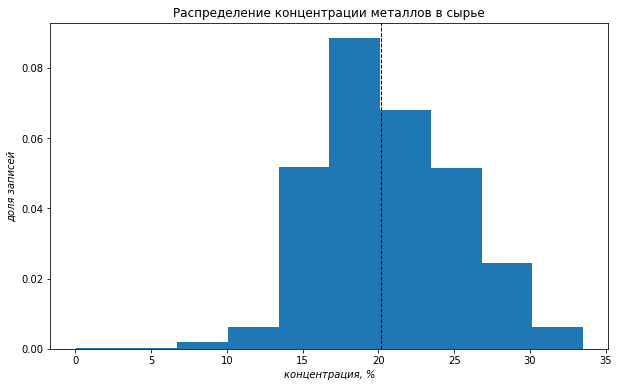

In [49]:
(full['rougher.input.feed_pb'] + full['rougher.input.feed_ag'] + full['rougher.input.feed_au']).hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=(full['rougher.input.feed_pb'] + full['rougher.input.feed_ag'] + full['rougher.input.feed_au']).median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации металлов в сырье')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Грубая обработка повышает концентрацию металов, однако в части сырья их концентрация падает почти до нуля.

Text(0.5, 0, 'концентрация, %')

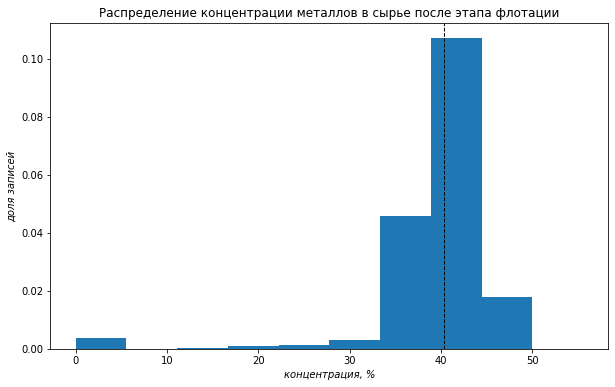

In [50]:
(full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_au'] + full['rougher.output.concentrate_ag']).hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=(full['rougher.output.concentrate_pb'] + full['rougher.output.concentrate_au'] + full['rougher.output.concentrate_ag']).median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации металлов в сырье после этапа флотации')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Первый этап очистки также увеличивает концентрацию, но кроме того увеличивает и дисперсию распределения металов.

Text(0.5, 0, 'концентрация, %')

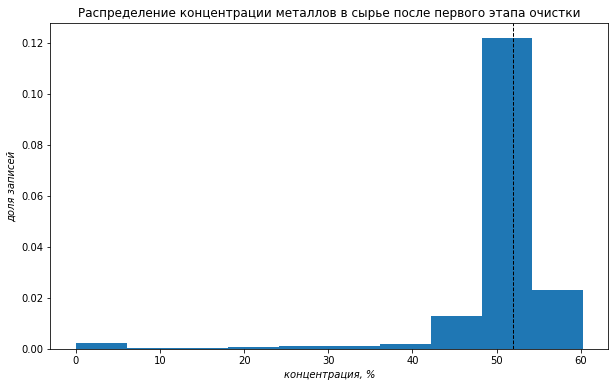

In [51]:
(full['primary_cleaner.output.concentrate_pb'] + full['primary_cleaner.output.concentrate_au'] + full['primary_cleaner.output.concentrate_ag']).hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=(full['primary_cleaner.output.concentrate_pb'] + full['primary_cleaner.output.concentrate_au'] + full['primary_cleaner.output.concentrate_ag']).median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации металлов в сырье после первого этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

Второй этап очистки продолжает увеличивать суммарную концентрацию металлов, но кроме этого значительно уменьшает дисперсию распределения, можно предположить, что последнее является главной задачей этого этапа.

Text(0.5, 0, 'концентрация, %')

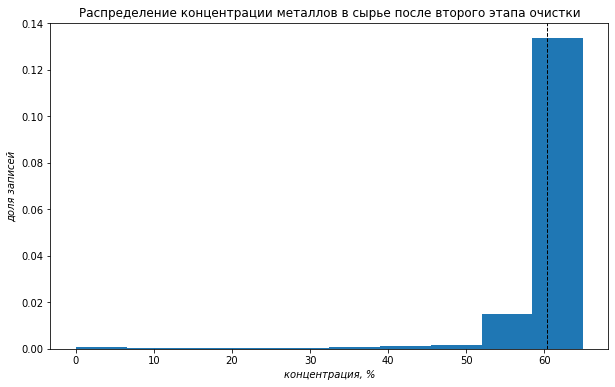

In [52]:
(full['final.output.concentrate_pb'] + full['final.output.concentrate_au'] + full['final.output.concentrate_ag']).hist(figsize=(10,6), grid=False, density=True)
plt.axvline(x=(full['final.output.concentrate_pb'] + full['final.output.concentrate_au'] + full['final.output.concentrate_ag']).median(), color='#000000', ls='--', linewidth=1)
plt.title('Распределение концентрации металлов в сырье после второго этапа очистки')
plt.ylabel('доля записей', style='italic')
plt.xlabel('концентрация, %', style='italic')

---

Для большей наглядности можно взглянуть на медианы концентраций сырья на каждом из этапов, чтобы можно было удобнее их сравнивать друг между другом и отслеживать динамику распределений.

Из рисунка видно, что в изначальном сырье концентрация серебра наибольшая, а концентрация золота лишь на втором месте из всех металлов. После грубой очистки ситуация изменяется и концентрация золота становится наибольшей, кроме того на данном этапе увеличивается концентрация всех металлов в сырье. После первого этапа очистки концентрация серебра уменьшается, но концентрации свинца и золота вырастают, последняя при этом демонстрирует наибольший рост. После этапа второй очистки суммарная концетрация металлов ~60%, при этом значительную часть этой концентрации занимает золото, которая повысилась по сравнению с предыдущем этапом. Также на данном этапе продолжает уменьшаться концентрация серебра, но концентрация свинца остаётся неизменной по сравнению с предыдущем этапом.

Text(0.5, 0, 'этап')

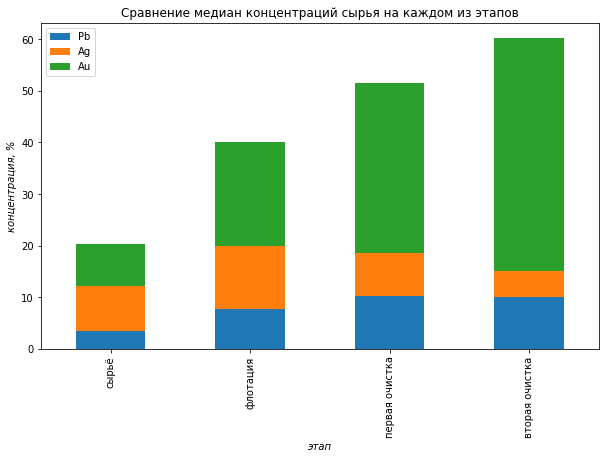

In [53]:
(
    pd.DataFrame(data={'Pb' : [full['rougher.input.feed_pb'].median(), full['rougher.output.concentrate_pb'].median(), full['primary_cleaner.output.concentrate_pb'].median(), full['final.output.concentrate_pb'].median()],
                       'Ag' : [full['rougher.input.feed_ag'].median(), full['rougher.output.concentrate_ag'].median(), full['primary_cleaner.output.concentrate_ag'].median(), full['final.output.concentrate_ag'].median()],
                       'Au' : [full['rougher.input.feed_au'].median(), full['rougher.output.concentrate_au'].median(), full['primary_cleaner.output.concentrate_au'].median(), full['final.output.concentrate_au'].median()]
                      },
                 index=['сырьё', 'флотация', 'первая очистка', 'вторая очистка'])
    .plot(kind='bar', stacked=True, figsize=(10,6), align='center')
)
plt.title('Сравнение медиан концентраций сырья на каждом из этапов')
plt.ylabel('концентрация, %', style='italic')
plt.xlabel('этап', style='italic')

### Размеры гранул

Можно также сравнить между собой распределения размеров гранул оригинального сырья в обучающей и тестовой выборках, чтобы убедиться в том, что они различаются несильно или не различаются совсем, потому что в противном случая оценка модели будет некорректной.

(0.0, 120.0)

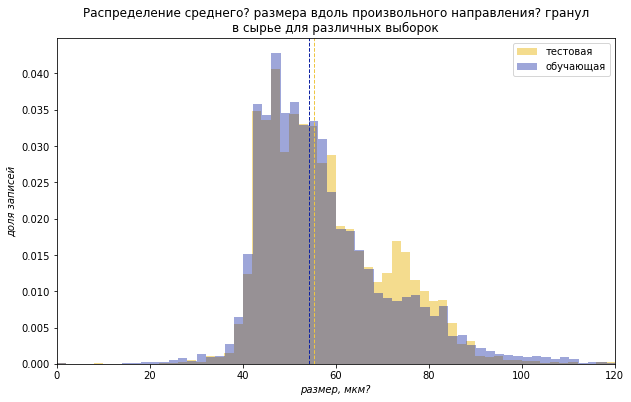

In [54]:
test['rougher.input.feed_size'].hist(
                                        figsize=(10,6),
                                        grid=False, bins=round(test['rougher.input.feed_size'].max() / 2),
                                        density=True,
                                        alpha=0.6,
                                        color='#EEC643'
                                    )
train['rougher.input.feed_size'].hist(
                                        figsize=(10,6),
                                        grid=False,
                                        bins=round(train['rougher.input.feed_size'].max() / 2),
                                        density=True,
                                        alpha=0.4,
                                        color='#0D21A1'
                                     )
plt.title('Распределение среднего? размера вдоль произвольного направления? гранул\nв сырье для различных выборок')
plt.ylabel('доля записей', style='italic')
plt.xlabel('размер, мкм?', style='italic')
plt.legend(['тестовая','обучающая'])
plt.axvline(x=test['rougher.input.feed_size'].median(), color='#EEC643', ls='--', linewidth=1)
plt.axvline(x=train['rougher.input.feed_size'].median(), color='#0D21A1', ls='--', linewidth=1)
plt.xlim(0, 120)

<div class="alert alert-block alert-info">
<b>Комментарий:</b>
Я не нашёл информации о том что в указанных данных означает "размер гранул" (очевидно, что гранулы имеют разный размер и неправильную форму, но в имеющихся данных мы имеем только одну цифру размера, связанную с конкретной датой), причём указание на единицы измерения этой величины также отсутсвуют, поэтому на данных графиках присутсвует ряд смелых предположений относительно этих данных. 
</div>

Хотя распределение размеров гранул тестовой выборки, как видно из приведённого рисунка и имеет небольшой дополнительный пик, мы не будем считать это за сильное различе между выборками, что позволяет нам быть в большей уверенности относительно корректности последующих оценок моделей.

## Модель

В процессе подбора наиболее подходящей модели будет необходимо каким-либо образом оценивать качество этих моделей. Для этого можно ввести подходящуюю метрику качества и вычислять её в процентах.

In [55]:
# симметричное среднее абсолютное процентное отклонение
# целевой признак, предсказание
def smape(a,b):
    return (2 * np.abs(a - b) / (np.abs(a) + np.abs(b))).mean()

# итоговое симметричное среднее абсолютное процентное отклонение
# целевой признак чернового, предсказание чернового, целевой признак финальный, предсказание финальный
def proba(rv,rp,fv,fp):
    return smape(rv,rp) * 25 + smape(fp,fv) * 75 # проценты

### Поиск

#### Первый вариант

Обучим множество моделей и сравним их качество кросс-валидацией. Поскольку, как указано в функции выше, в данном анализе для определения качества моделей нам потребуются две величины: обогащение сырья после флотации и финальное обогащени сырья, то и в процессе сравнения моделей нам придётся их находить. Обогащение сырья после какого либо этапа мы можем найти, зная концентрации вещества в сырье перед этим этапом, после этого этапа и в отвальном хвосте, через функцию, описанную в [начале данного анализа](#m1), но тестовые данные не предполагают наличия знания о каких-либо концентрациях после процесса, поэтому задачей наших моделей будет предсказать недостающие данные:

1. Концентрацию золота в сырье после флотации (`rougher.output.concentrate_au`)
2. Концентрацию золота в отвальном хвосте после флотации (`rougher.output.tail_au`)
3. Концентрацию золота в финальном сырье (`final.output.concentrate_au`)
4. Концентрацию золота в итоговом отвальном хвосте (`final.output.tail_au`)

После этого, у нас появится возможность вычислить метрики качества моделей и сравнить их друг с другом. Учитывая, что нам требуется предсказать сразу четыре величины, будем подбирать модель под каждую из них, чтобы найти лучшее сочетание.

In [56]:
rrrr = 42 # random_state

model = [LinearRegression(), # метод наименьших квадратов
         RandomForestRegressor(random_state=rrrr, n_estimators=10, max_features ='sqrt'), # случайный лес
         DecisionTreeRegressor(random_state=rrrr), # дерево решений
         KNeighborsRegressor(n_neighbors=4), # метод ближайших соседей
         SVR(), # метод опорных векторов
        ]

# конечная цель - получить модель, которая будет предсказывать на основании тестовых данных, поэтому обучающие данные должны содержать те признаки, которые есть в тестовых данных (наверное)
f = train[train.columns.intersection(test.columns)]
# признаки (предпологается, что целевые признаки не зависят от даты)
f = f.drop(['date'], axis=1)
# целевые признаки
t = [
        train['rougher.output.concentrate_au'], # концентрация в сырье после флотации
        train['rougher.output.tail_au'],        # концентрация в отвальном хвосте после флотации
        train['final.output.concentrate_au'],   # концентрация в финальном сырье
        train['final.output.tail_au']           # концентрация в финальном отвальном хвосте
    ]


pp = [] # предсказанные концентрации
q = 0   # их счётчик

# делаем все предсказания
n = int(len(train) / 5) # размер одного блока; 5 блоков кросс-валидации
for p in t:
    pp.append([])
    for m in model:
        pp[q].append(0)
        
        print(q, ':', str(m))
        d = 0
        for i in range(0, len(train) - n, n):
            print('.' * d + '*' + '.' * (5 - d - 1)); d = d + 1

            # *
            vld_index = [j for j in range(i,i + n)]
            f_vld = f.loc[vld_index]
            
            # .
            trn_index = [j for j in range(0,i)] + [k for k in range(i + n,len(train))]
            f_trn = f.loc[trn_index]
            t_trn = p.loc[trn_index]
            
            m = m.fit(f_trn,t_trn)
            
            pp[q][-1] = pp[q][-1] + m.predict(f_vld)
            
        pp[q][-1] = pp[q][-1] / 5 # возможно, это не совсем правильно с точки зрения математики, но искать потом все эти данные в трёхмерном массиве из перебора по одной переменной мне представляет проблематичным
    q = q + 1

0 : LinearRegression()
*....
.*...
..*..
...*.
....*
0 : RandomForestRegressor(max_features='sqrt', n_estimators=10, random_state=42)
*....
.*...
..*..
...*.
....*
0 : DecisionTreeRegressor(random_state=42)
*....
.*...
..*..
...*.
....*
0 : KNeighborsRegressor(n_neighbors=4)
*....
.*...
..*..
...*.
....*
0 : SVR()
*....
.*...
..*..
...*.
....*
1 : LinearRegression()
*....
.*...
..*..
...*.
....*
1 : RandomForestRegressor(max_features='sqrt', n_estimators=10, random_state=42)
*....
.*...
..*..
...*.
....*
1 : DecisionTreeRegressor(random_state=42)
*....
.*...
..*..
...*.
....*
1 : KNeighborsRegressor(n_neighbors=4)
*....
.*...
..*..
...*.
....*
1 : SVR()
*....
.*...
..*..
...*.
....*
2 : LinearRegression()
*....
.*...
..*..
...*.
....*
2 : RandomForestRegressor(max_features='sqrt', n_estimators=10, random_state=42)
*....
.*...
..*..
...*.
....*
2 : DecisionTreeRegressor(random_state=42)
*....
.*...
..*..
...*.
....*
2 : KNeighborsRegressor(n_neighbors=4)
*....
.*...
..*..
...*.
....*
2 

In [57]:
best_score = 101 # лучшее качество

# высчитываем по предсказаному целевые значения
k = 0
while True:
    if (int(int(int(k / len(pp[0])) / len(pp[0])) / len(pp[0])) == len(pp[0])):
        break

    score = []
    for i in range(0, len(train) - n, n): # тот же цикл
        # *
        # оригинальные значения
        vld_index = [j for j in range(i,i + n)]
        tr_vld = train.loc[vld_index, 'rougher.output.recovery'] # обогащение сырья после флотации
        tf_vld = train.loc[vld_index, 'final.output.recovery']   # итоговое обогащение сырья

        # предсказания
        tr_prd = (bogat(
                            pp[0][int(int(int(k / len(pp[0])) / len(pp[0])) / len(pp[0]))],
                            f.loc[vld_index, 'rougher.input.feed_au'], # знаем в тестовой выборке
                            pp[1][int(int(k / len(pp[0])) / len(pp[0])) % len(pp[0])]
                        ) * 100)
        tf_prd = (bogat(
                            pp[2][int(k / len(pp[0])) % len(pp[0])],
                            f.loc[vld_index, 'rougher.input.feed_au'], # знаем в тестовой выборке
                            pp[3][k % len(pp[0])]
                        ) * 100)
        
        score.append(proba(tr_vld, tr_prd, tf_vld, tf_prd))
    score = pd.Series(score).mean()
#    print(k, ' : ', score, '\n',
#              int(int(int(k / len(pp[0])) / len(pp[0])) / len(pp[0])),
#              int(int(k / len(pp[0])) / len(pp[0])) % len(pp[0]),
#              int(k / len(pp[0])) % len(pp[0]),
#              k % len(pp[0])
#         )
    if (score < best_score):
        best_score = score # лучшее качество
        # название моделей
        name = str(model[int(int(int(k / len(pp[0])) / len(pp[0])) / len(pp[0]))]) + ' + ' + str(model[int(int(k / len(pp[0])) / len(pp[0])) % len(pp[0])]) + ' + ' + str(model[int(k / len(pp[0])) % len(pp[0])]) + ' + ' + str(model[k % len(pp[0])])
    k = k + 1

print(name, '\n>', best_score)

LinearRegression() + SVR() + LinearRegression() + LinearRegression() 
> 14.499041214029882


Получаем, что оптимальной моделью для всех величин является модель наименьших квадратов, кроме концентрации золота в отвальном хвосте после флотации, для которой лучшей моделью является метод опорных векторов. Среднее отклонение при сочетании выбора таких методов составляет ~14.5%.

#### Второй вариант

Кроме обозначенного выше способа можно попробовать вычислить обогащение сырья после флотации и итоговое обогащение сырья напрямую, не прибегая к опосредованым вычислениям.

In [58]:
rrrr = 42 # random_state

model = [LinearRegression(), # метод наименьших квадратов
         RandomForestRegressor(random_state=rrrr, n_estimators=10, max_features ='sqrt'), # случайный лес
         DecisionTreeRegressor(random_state=rrrr), # дерево решений
         KNeighborsRegressor(n_neighbors=4), # метод ближайших соседей
         SVR(), # метод опорных векторов
        ]

# конечная цель - получить модель, которая будет предсказывать на основании тестовых данных, поэтому обучающие данные должны содержать те признаки, которые есть в тестовых данных (наверное)
f = train[train.columns.intersection(test.columns)]
# признаки (предпологается, что целевые признаки не зависят от даты)
f = f.drop(['date'], axis=1)
# целевые признаки
tr = train['rougher.output.recovery'] # обогащение сырья после флотации
tf = train['final.output.recovery']   # итоговое обогащение сырья


best_score = 101 # лучшее качество

# очевидно можно сделать оптимальнее, а не перебирать одни и те же модели, но пока это выполняется за разумное время, пусть это будут проблемы компьютера
for mr in model:
    for mf in model:
        m_name = str(mr) + ' + ' + str(mf)
        print(m_name)
        
        score = [] # качество
        n = int(len(train) / 5) # размер одного блока; 5 блоков кросс-валидации
        
        d = 0
        for i in range(0, len(train) - n, n):
            print('.' * d + '*' + '.' * (5 - d - 1)); d = d + 1
            
            vld_index = [j for j in range(i,i + n)] # *
            trn_index = [j for j in range(0,i)] + [k for k in range(i + n,len(train))] # .
            
            # .
            f_trn = f.loc[trn_index]
            tr_trn = tr.loc[trn_index]
            tf_trn = tf.loc[trn_index]
            # *
            f_vld = f.loc[vld_index]
            tr_vld = tr.loc[vld_index]
            tf_vld = tf.loc[vld_index]
            
            mr = mr.fit(f_trn,tr_trn)
            mf = mf.fit(f_trn,tf_trn)
            
            score.append(proba(tr_vld,mr.predict(f_vld),tf_vld,mf.predict(f_vld)))
        
        score = pd.Series(score).mean()
        print('>', score)
        if score < best_score:
            best_name = m_name # сохраним название
            best_score = score # лучшее качество

print('---\n', best_name, '\n', best_score)

LinearRegression() + LinearRegression()
*....
.*...
..*..
...*.
....*
> 15.57288517348763
LinearRegression() + RandomForestRegressor(max_features='sqrt', n_estimators=10, random_state=42)
*....
.*...
..*..
...*.
....*
> 12.691242822352024
LinearRegression() + DecisionTreeRegressor(random_state=42)
*....
.*...
..*..
...*.
....*
> 19.955692058740944
LinearRegression() + KNeighborsRegressor(n_neighbors=4)
*....
.*...
..*..
...*.
....*
> 13.926034351349267
LinearRegression() + SVR()
*....
.*...
..*..
...*.
....*
> 11.888001954221172
RandomForestRegressor(max_features='sqrt', n_estimators=10, random_state=42) + LinearRegression()
*....
.*...
..*..
...*.
....*
> 12.108054674065077
RandomForestRegressor(max_features='sqrt', n_estimators=10, random_state=42) + RandomForestRegressor(max_features='sqrt', n_estimators=10, random_state=42)
*....
.*...
..*..
...*.
....*
> 17.160018981457725
RandomForestRegressor(max_features='sqrt', n_estimators=10, random_state=42) + DecisionTreeRegressor(random_s

Самым оптимальным для предсказания обогащения сырья после флотации оказался метод опорных векторов, а для предсказания итогового обогащения сырья метод наименьших квадратов. Среднее отклонение при сочетании выбора таких методов составляет ~11.5%.

### Тест

Поскольку поиск подходящих методов вторым вариантом показал чуть меньшее отклонение дальнейшие рассуждения будем проводить с данными из второго варианта. Обучим модели на всех обучающих данных и проверим их на второй половине полных данных (которые соответсвуют тестовым).

In [59]:
# конечная цель - получить модель, которая будет предсказывать на основании тестовых данных, поэтому обучающие данные должны содержать те признаки, которые есть в тестовых данных (наверное)
f = train[train.columns.intersection(test.columns)]
# признаки (предпологается, что целевые признаки не зависят от даты)
f = f.drop(['date'], axis=1)
# целевые признаки
tr = train['rougher.output.recovery'] # обогащение сырья после флотации
tf = train['final.output.recovery']   # итоговое обогащение сырья


# применяем лучшие модели
mr = SVR() # метод опорных векторов
mf = LinearRegression() # метод наименьших квадратов

# тренируем лучшие модели на всей обучающей выборке
mr = mr.fit(f,tr)
mf = mf.fit(f,tf)


# признаки тестовых данных (предпологается, что целевые признаки не зависят от даты)
t = test.drop(['date'], axis=1)

# проверяем на полных данных
# целевые признаки
tr = full.loc[full['date'] >= test['date'].min(), 'rougher.output.recovery'] # обогащение сырья после флотации
tf = full.loc[full['date'] >= test['date'].min(), 'final.output.recovery']   # итоговое обогащение сырья

proba(tr,mr.predict(t),tf,mf.predict(t))

7.4891303655163375

Симметричное среднее абсолютное процентное отклонение посчитанное на тестовых данных ~7.5%.

## Вывод

В ходе данного исследования была получена модель, способная предсказать обогащение сырья золотом после флотации и итоговое обогащение золотом сырья по предварительным параметрам сырья, ещё не прошедшего этап грубой обработки. Симметричное среднее абсолютное процентное отклонение между предсказанными данными и тестовыми составило ~7.5%. Данная модель поможет успешно анализировать эффективность производства, чтобы не запускать предприятие с убыточными характеристиками.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке